# Introduction to Bayesian Inference and Python Emcee

In [23]:
##
# Ayush Pandey
# Apr 7th 2022
## 
## Note:
# Parts of this notebook are directly taken 
# from the emcee package documentation
# available here: https://emcee.readthedocs.io/en/stable/
##


# Plotting parameters
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

## Bayesian Inference: Linear Fit
With this example, we identify the parameters of a linear equation, $y = mx + b$. Given noisy data of the output $y$, we estimate the posterior distributions of the parameters $m$ and $b$. 

### Create artificial data:

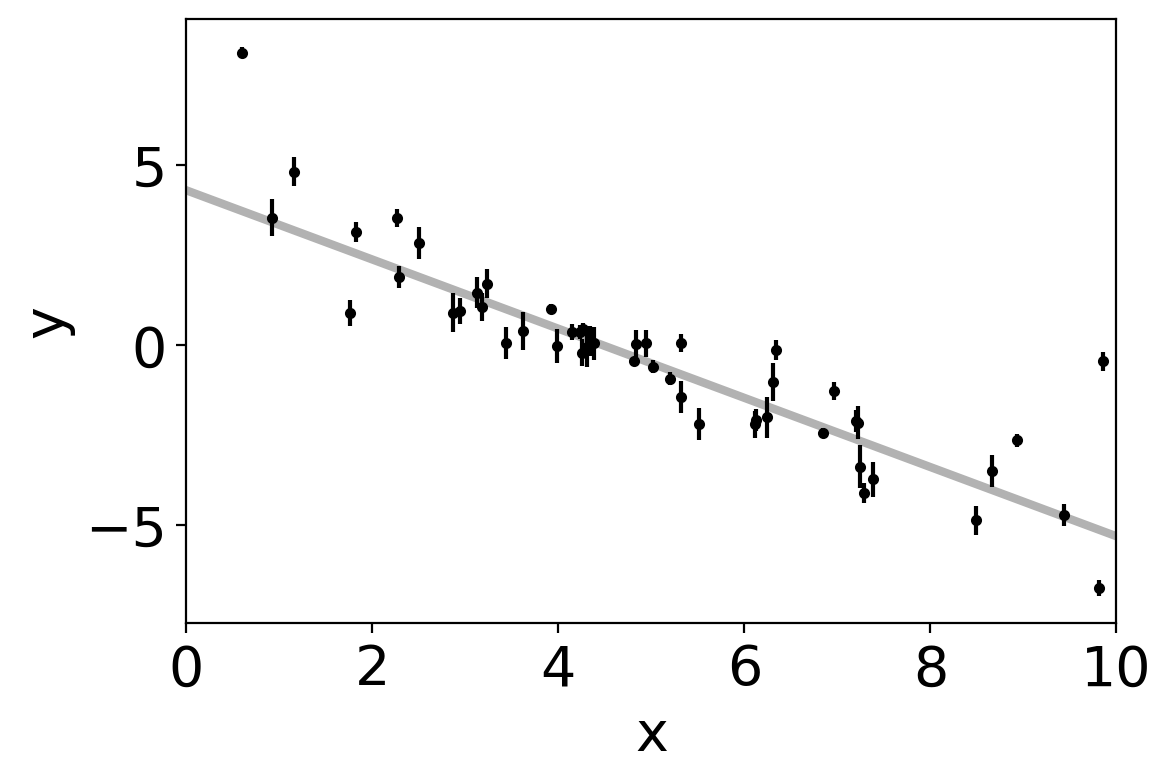

In [24]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

## Least-Squares Fit:

Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


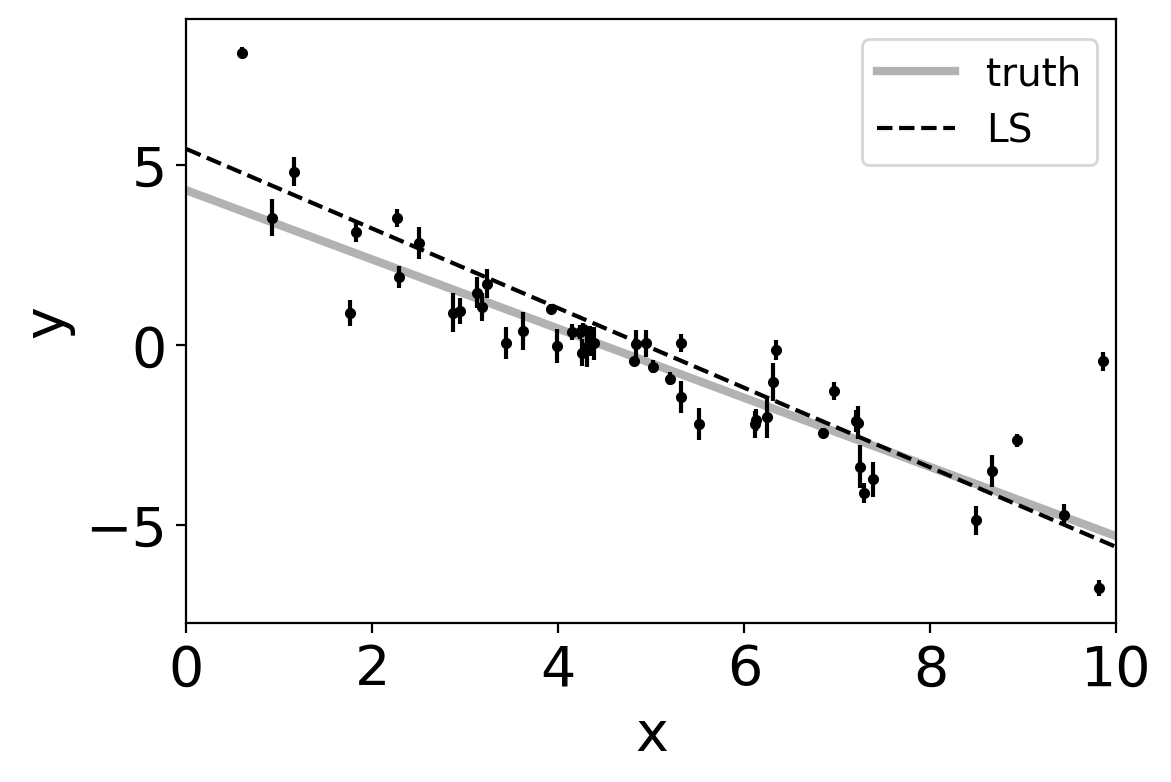

In [25]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

## Maximum likelihood estimation

The least squares solution found in the previous section is the maximum
likelihood result for a model where the error bars are assumed correct,
Gaussian and independent.
We know, of course, that this isn't the right model.
Unfortunately, there isn't a generalization of least squares that supports a
model like the one that we know to be true.
Instead, we need to write down the likelihood function and numerically
optimize it.
In mathematical notation, the correct likelihood function is:

$$
    \ln\,p(y\,|\,x,\sigma,m,b,f) =
    -\frac{1}{2} \sum_n \left[
        \frac{(y_n-m\,x_n-b)^2}{s_n^2}
        + \ln \left ( 2\pi\,s_n^2 \right )
    \right]
$$

where

$$
    s_n^2 = \sigma_n^2+f^2\,(m\,x_n+b)^2 \quad .
$$

This likelihood function is simply a Gaussian where the variance is
underestimated by some fractional amount:  $f$.
In Python, you would code this up as:

Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


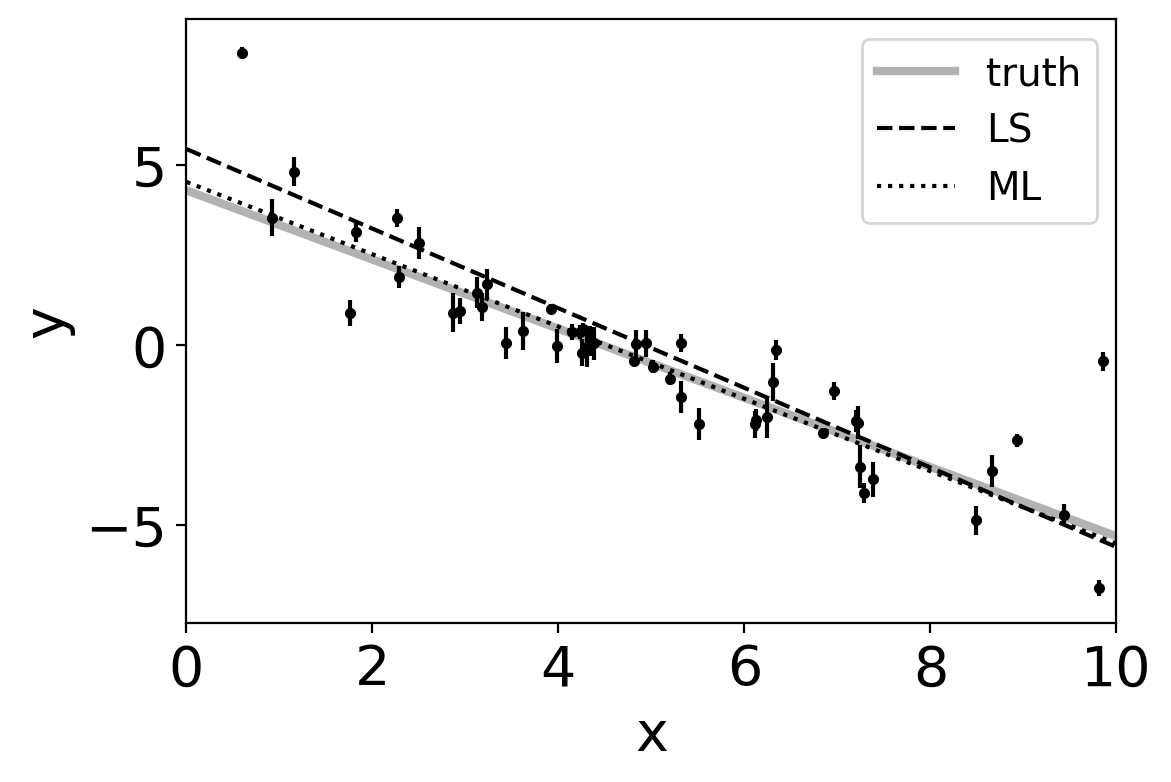

In [26]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, 
                    np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

## Markov Chain Monte Carlo for Parameter Inference

The parameter estimates do not reflect the uncertainties and noise in the data in maximum-likelihood estimate. So, we cannot estimate the uncertainties in $m$ and $b$. Further, it may not always be feasible to use `scipy.optimize.minimize` to obtain maximum likelihood estimates. MCMC is a hammer that can be applied to all kinds of problems! 

In [6]:
cost_progress = []
def log_prior(theta):
    m, b = theta
    if -500.0 < m < 500 and -1100.0 < b < 1100.0:
        return 0.0
    return -np.inf

def log_likelihood(theta, x, y):
    m, b = theta
    model = m * x + b
    cost = - np.linalg.norm(y - model)
    cost_progress.append(cost)
    return cost

def log_probability(theta, x, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y)

In [7]:
import emcee

pos = 1*np.zeros(2) + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y))
sampler.run_mcmc(pos, 3000, progress=True);

C:\Users\apand\AppData\Local\Continuum\anaconda3\lib\site-packages\emcee\ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,
100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:04<00:00, 748.53it/s]


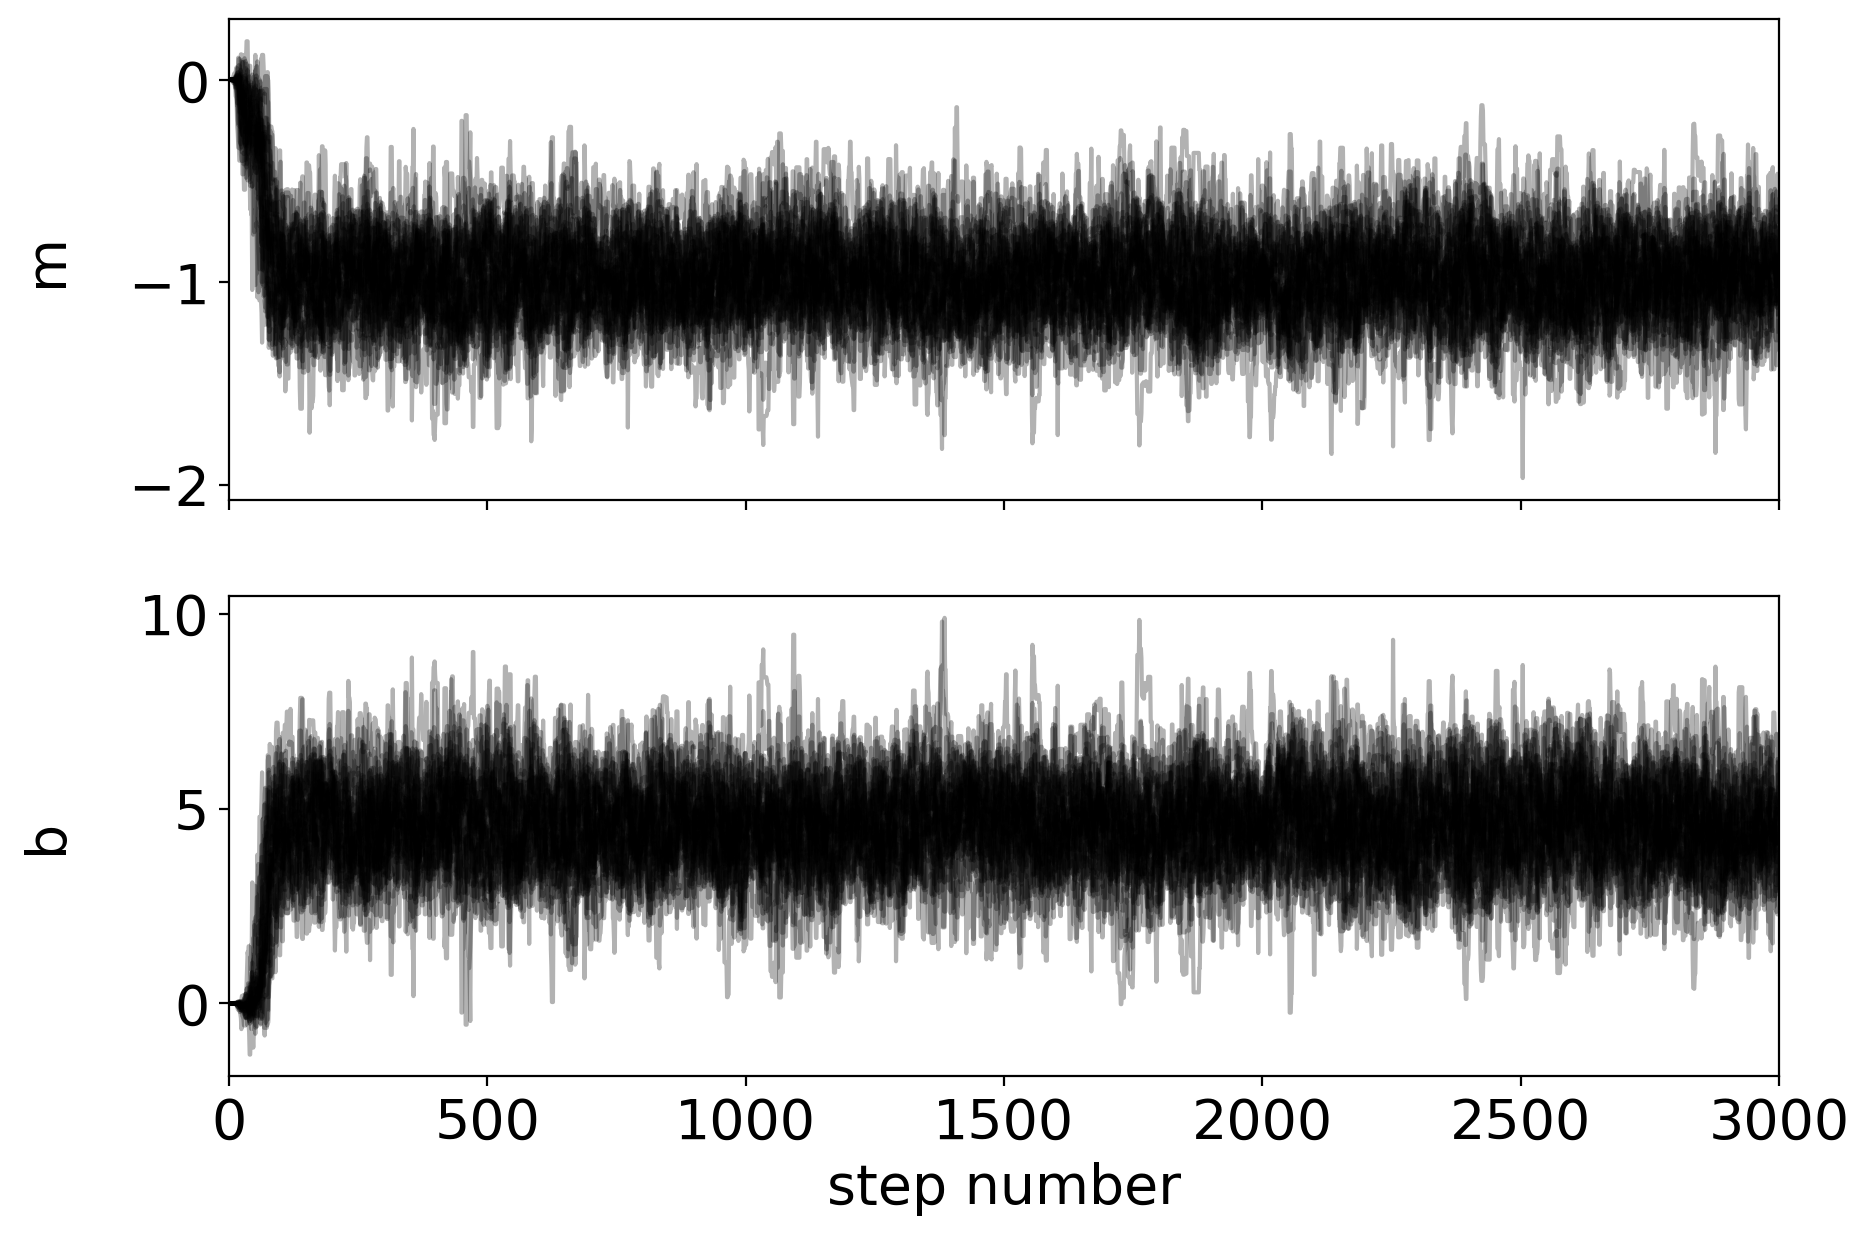

In [8]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
# labels = ["m", "b", "log(f)"]
labels = ["m", "b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

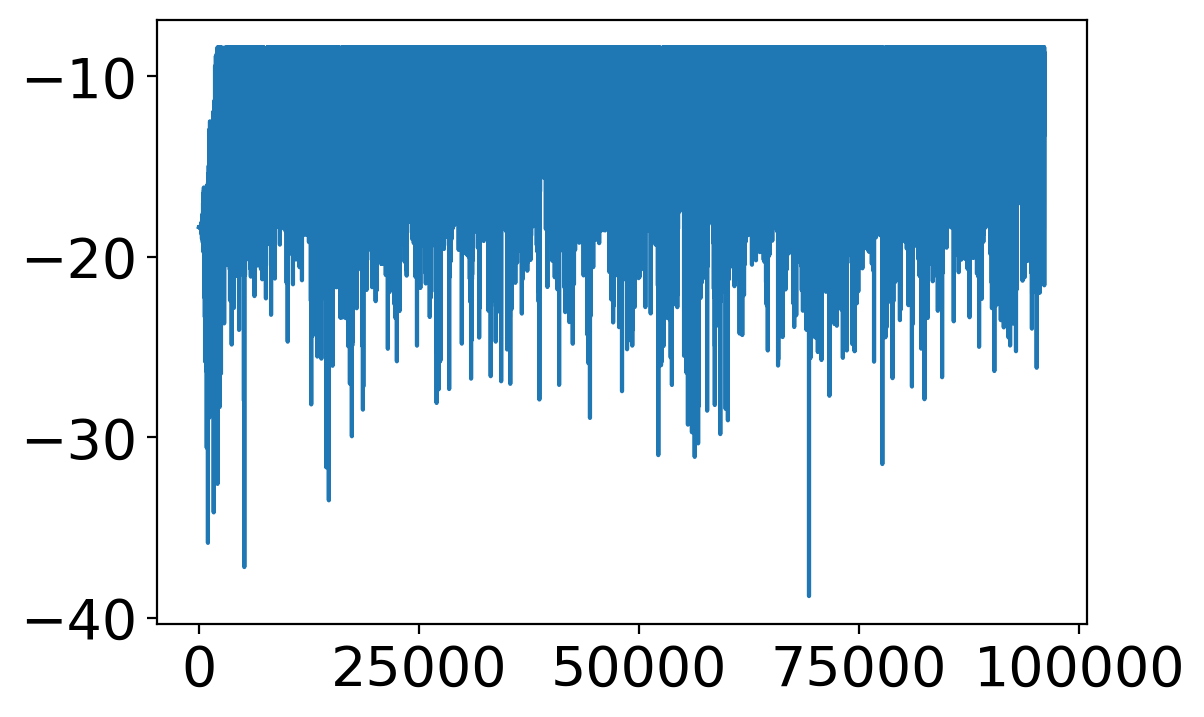

In [9]:
plt.plot(cost_progress)

(6176, 2)


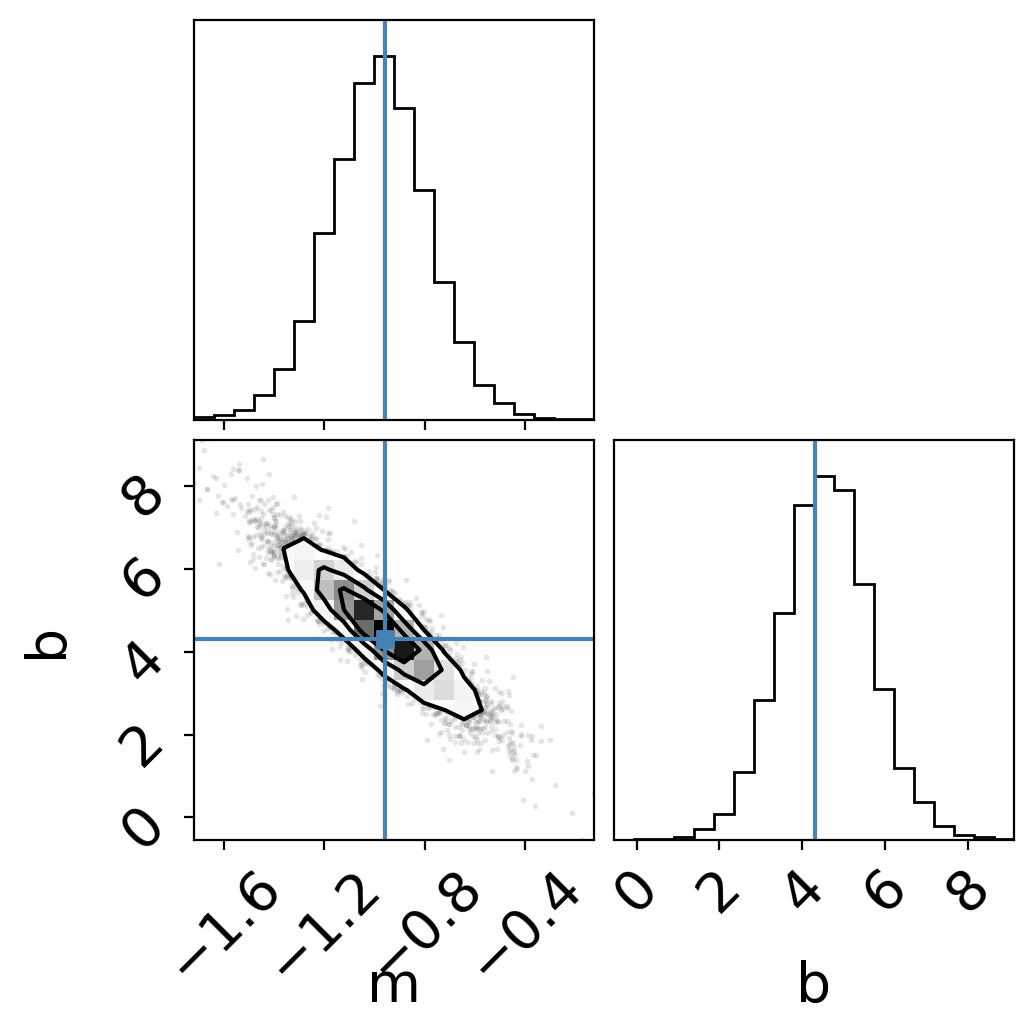

In [10]:
import corner
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)
fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true]
);

## Let us try a nonlinear model:

In [11]:
def gene_expression(x, t, *args):
    T, X = x
    k_tx, d_T, k_tl, d_X = args
    dT_dt = k_tx - d_T * T
    dX_dt = k_tl * T - d_X * X
    return np.array([dT_dt, dX_dt])

### Simulate the model and create synthetic data

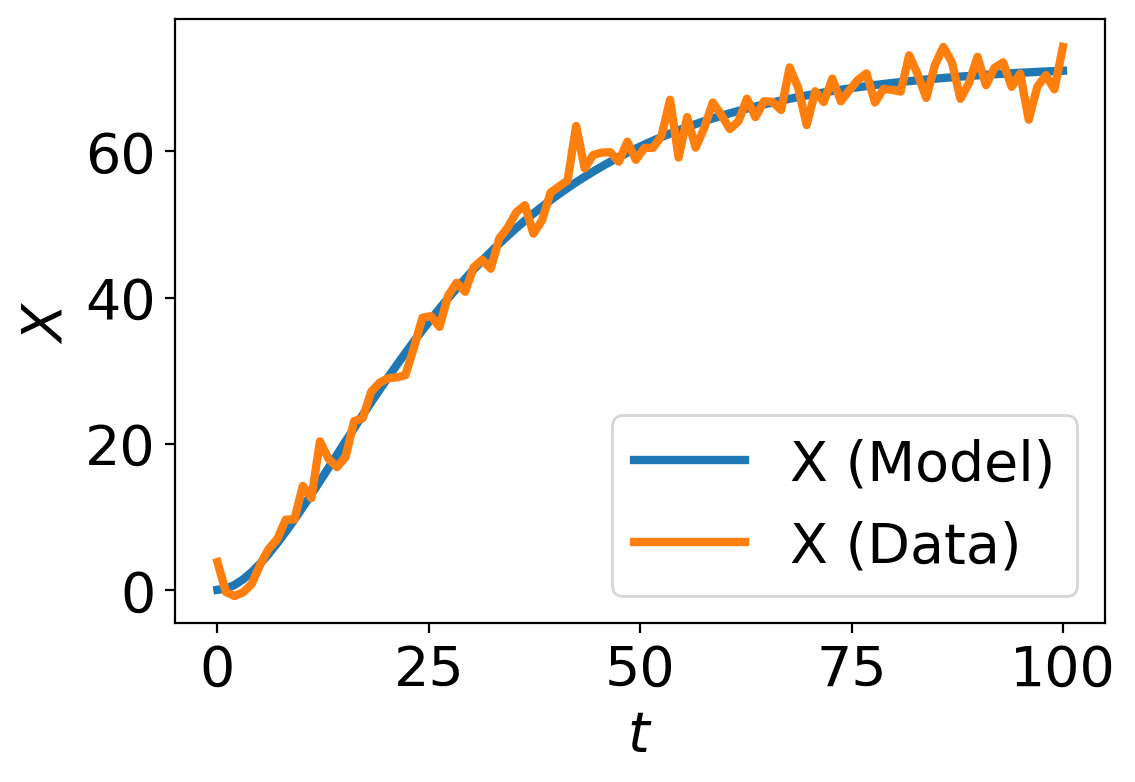

In [13]:
from scipy.integrate import odeint
# Define parameters
k_tx = 0.9
d_T = 0.1
k_tl = 0.4
d_X = 0.05

timepoints = np.linspace(0,100,100)
initial_cond = np.array([0, 0])
solution = odeint(func = gene_expression, y0 = initial_cond,
                   t = timepoints, args = (k_tx, d_T, k_tl, d_X))
data_protein = solution[:,1] + 2 * np.random.randn(np.shape(timepoints)[0])
ax = plt.axes()
ax.plot(timepoints, solution[:,1], lw = 3, label = 'X (Model)')
ax.plot(timepoints, data_protein, lw = 3, label = 'X (Data)')
ax.set_ylabel('$X$')
ax.set_xlabel('$t$')
ax.legend()

In [27]:
cost_progress = []
def log_prior(params):
    k_tx, d_T, k_tl, d_X = params
    if 0 < k_tx < 100 and 0 < d_T < 10 and 0 < k_tl < 1000 and 0 < d_X < 10:
        return 0.0
    return -np.inf

def log_likelihood(params, x, y):
    k_tx, d_T, k_tl, d_X = params
    sol = odeint(func = gene_expression, y0 = initial_cond,
                   t = x, args = (k_tx, d_T, k_tl, d_X))
    cost = - np.linalg.norm(y - sol[:,1])
    cost_progress.append(cost)
    return cost

def log_probability(params, x, y):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y)

In [28]:
import emcee
nwalkers = 32
pos = 1*np.array([k_tx, d_T, k_tl, d_X]) \
     + 1e-4 * np.random.randn(nwalkers, 4)
nwalkers, ndim = pos.shape
x = timepoints
y = data_protein
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y))
sampler.run_mcmc(pos, 4000, progress=True);

C:\Users\apand\AppData\Local\Continuum\anaconda3\lib\site-packages\emcee\ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,
100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:07<00:00, 59.48it/s]


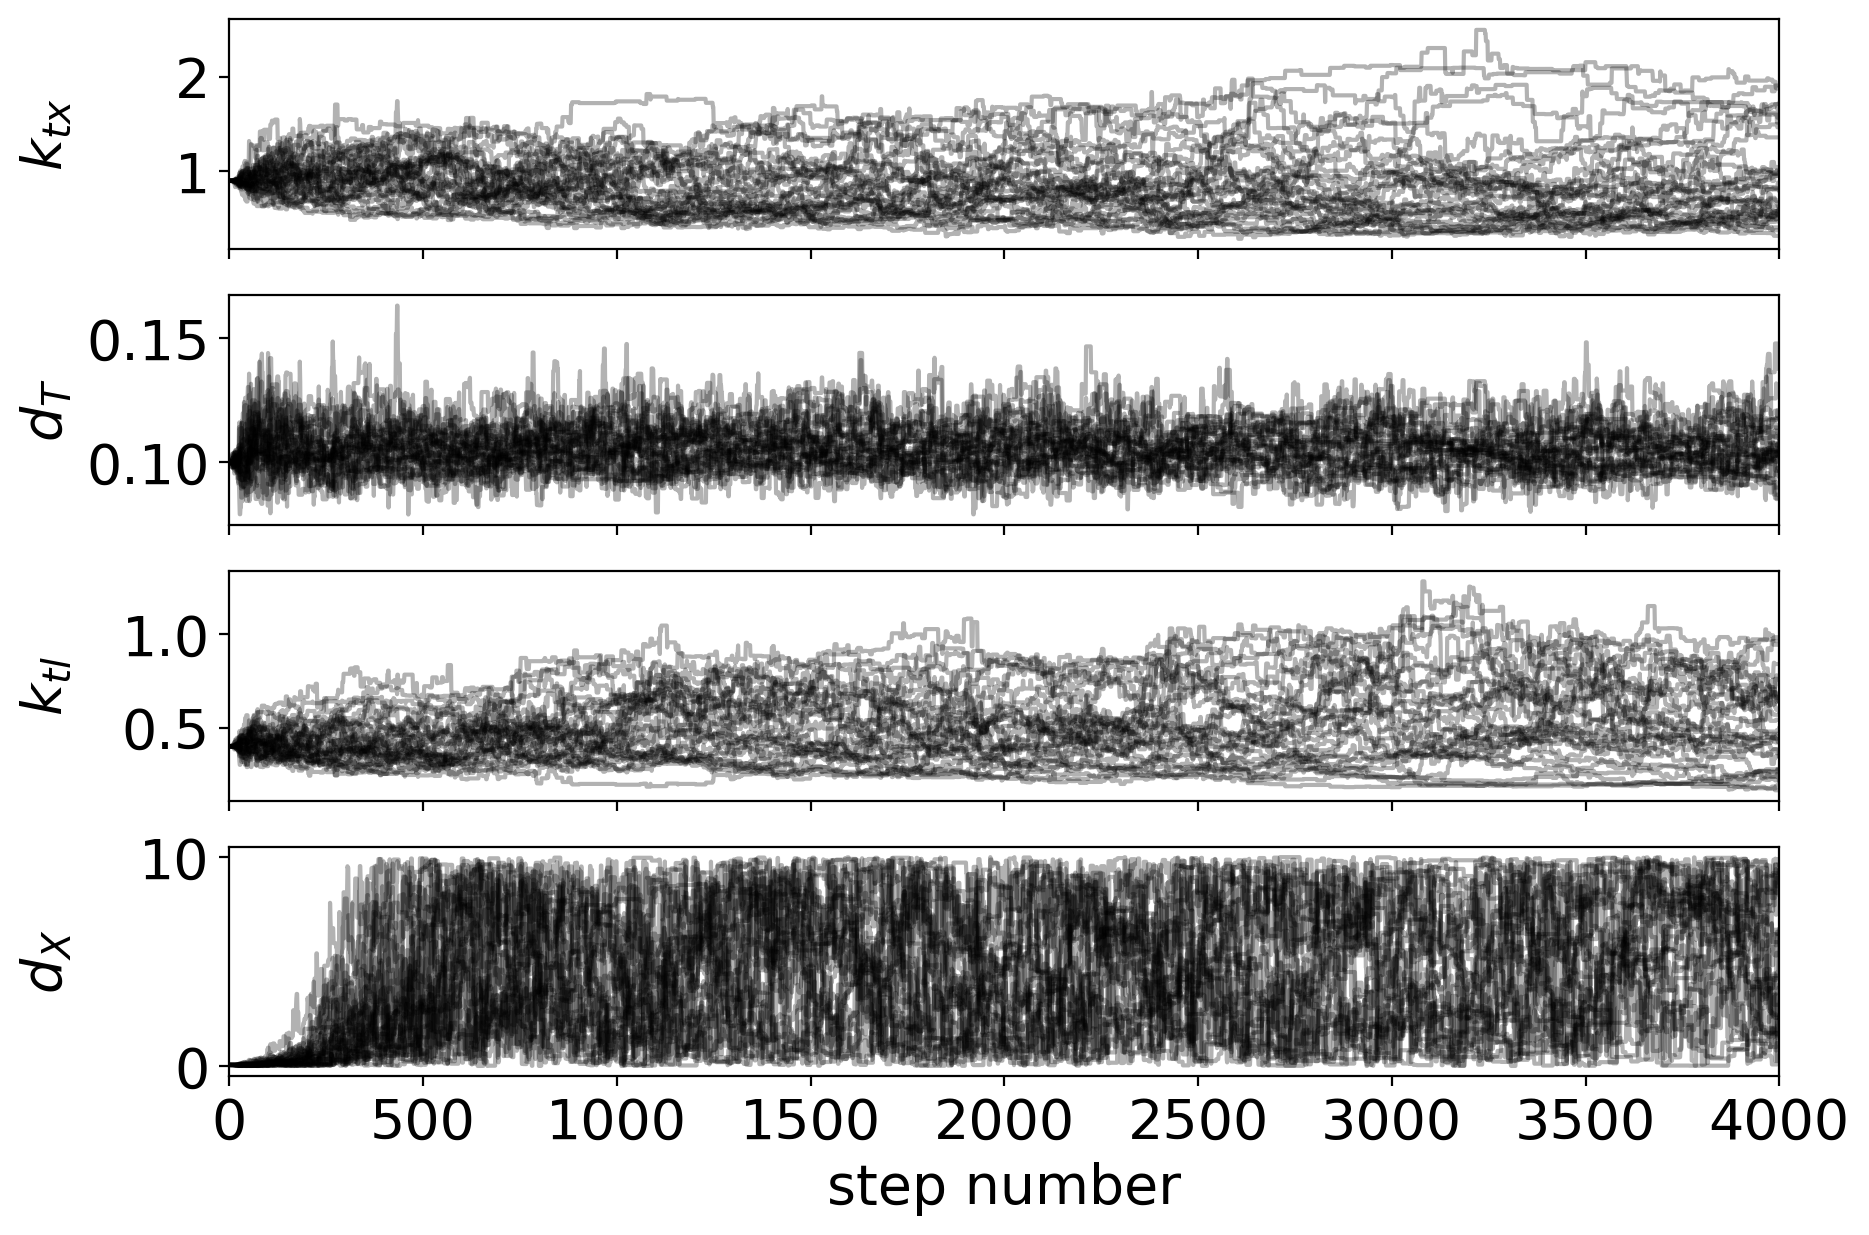

In [29]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

labels = ["$k_{tx}$", "$d_T$", "$k_{tl}$", "$d_X$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(8416, 4)


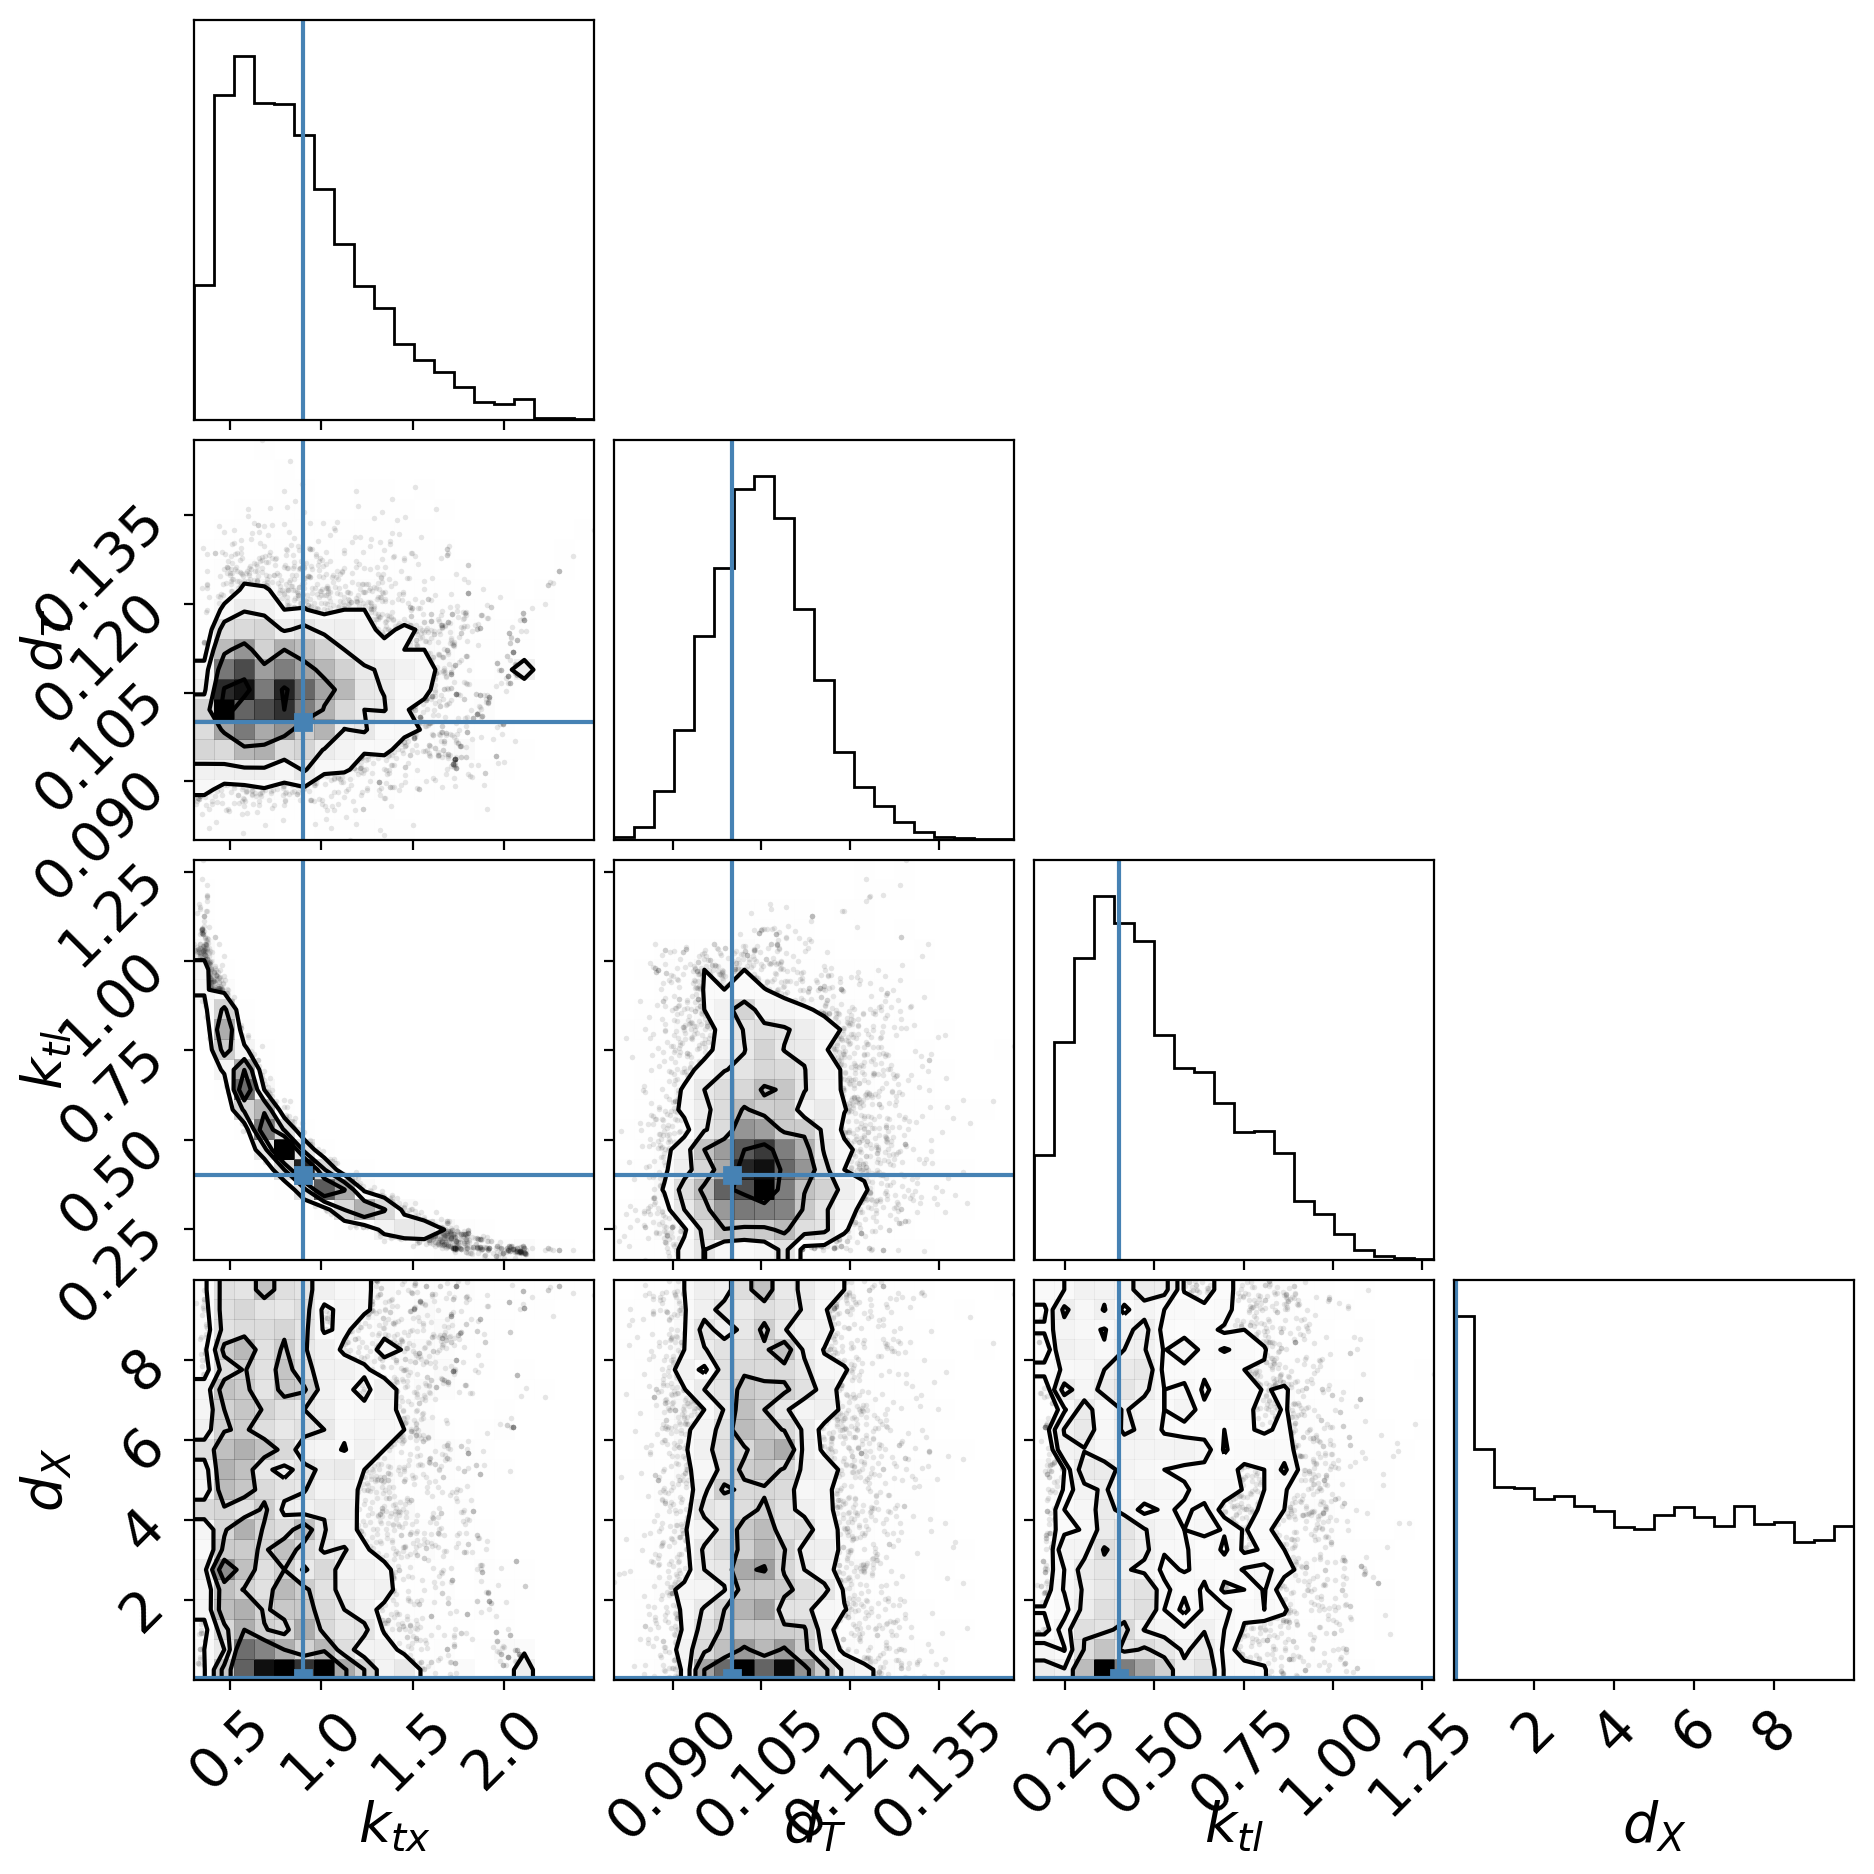

In [30]:
import corner
flat_samples = sampler.get_chain(discard=50, thin=15, flat=True)
print(flat_samples.shape)
fig = corner.corner(
    flat_samples, labels=labels, truths=[k_tx, d_T, k_tl, d_X]
);

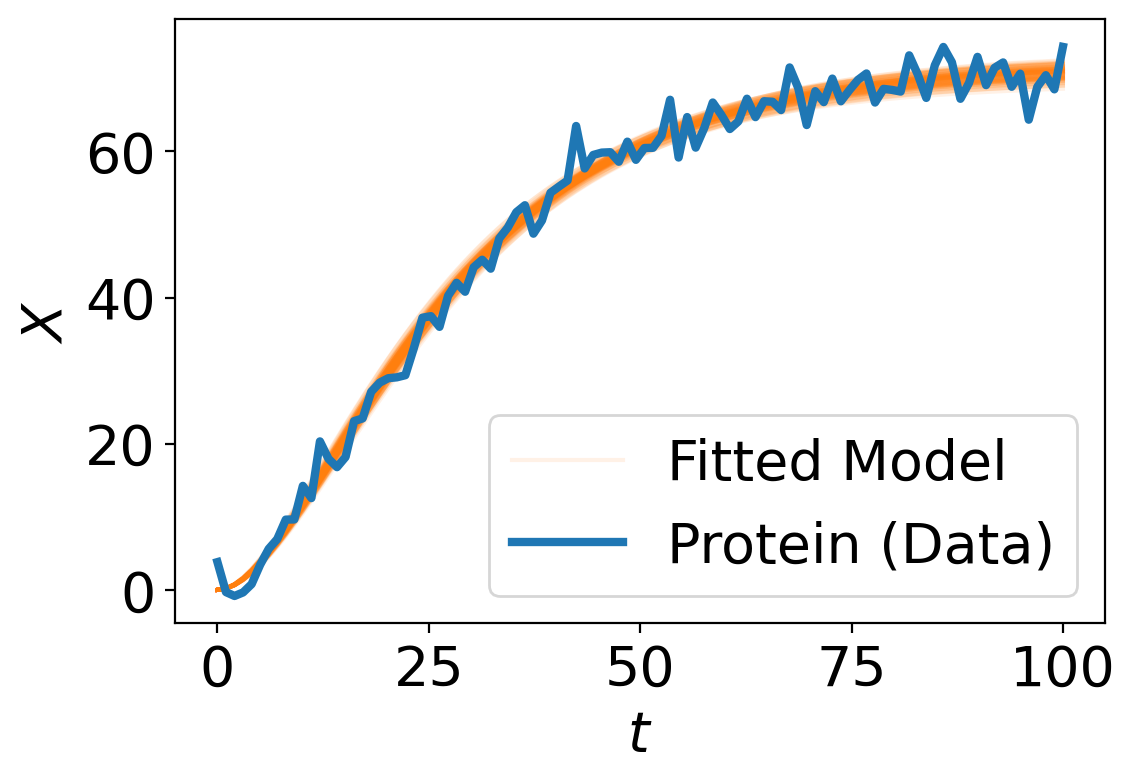

In [21]:
inds = np.random.randint(len(flat_samples), size=100)
ax = plt.axes()
add_label = True
for ind in inds:
    sample = flat_samples[ind]
    solution = odeint(func = gene_expression, y0 = initial_cond,
                      t = timepoints, args = tuple(sample))
    if add_label:
        ax.plot(timepoints, solution[:,1], "C1", alpha=0.1, 
                label = 'Fitted Model')
        add_label = False
    else:
        ax.plot(timepoints, solution[:,1], "C1", alpha=0.1)
        
ax.plot(timepoints, data_protein, lw = 3, label = 'Protein (Data)')
ax.set_ylabel('$X$')
ax.set_xlabel('$t$')
ax.legend()